In [1]:
import numpy as np
import torch
from transformers import *
from sklearn.mixture import GaussianMixture
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

You are using torchaudio==0.9.0, but torchaudio>=0.10.0 is required to use MCTCTFeatureExtractor. This requires torch>=1.10.0. Please upgrade torch and torchaudio.
You are using torch==1.9.0+cu111, but torch>=1.10.0 is required to use ViltModel. Please upgrade torch.


cuda


In [2]:
train_embeddings = {}
test_embeddings = {}
train_embeddings['sents'] = np.load('train/sents.npy')
train_embeddings['vectors'] = np.load('train/vectors.npy')
train_embeddings['labels'] = np.load('train/labels.npy')
test_embeddings['sents'] = np.load('test/sents.npy')
test_embeddings['vectors'] = np.load('test/vectors.npy')
test_embeddings['labels'] = np.load('test/labels.npy')

In [8]:
LABELS = ['it', 'koran', 'law', 'medical', 'subtitles']
N_CLUSTERS = 10
def GMM(data, num_clusters):
    model = GaussianMixture(
        n_components=num_clusters, 
        covariance_type='full', 
        max_iter=100, 
        random_state=0,
        verbose=1)

    model.fit(data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * 5
        for i, pred in enumerate(predictions):
            if pred == k:
                count[LABELS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (LABELS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [5]:
start = time.time()
model = GMM(train_embeddings['vectors'], 10)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False


/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Time taken to converge: 6.528545861906475 hrs.


In [6]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['labels'], train_pred, 10)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['labels'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_gmm_k10_distilBERT.npy', test_pred)

Train accuracy is 0.8928
Test accuracy is 0.8914


In [9]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: subtitles | Purity: 0.9910388196879913
Cluster-2 | label: koran | Purity: 0.7664417035140796
Cluster-3 | label: medical | Purity: 0.6407216673003145
Cluster-4 | label: it | Purity: 0.9798175449865015
Cluster-5 | label: medical | Purity: 0.9640118597280442
Cluster-6 | label: subtitles | Purity: 0.8580007487832273
Cluster-7 | label: law | Purity: 0.993904238989255
Cluster-8 | label: medical | Purity: 0.9905744733871795
Cluster-9 | label: it | Purity: 0.6098360655737705
Cluster-10 | label: law | Purity: 0.8746420830099816


In [10]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 3.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.272582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.066017
[t-SNE] KL divergence after 1000 iterations: 2.215315


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

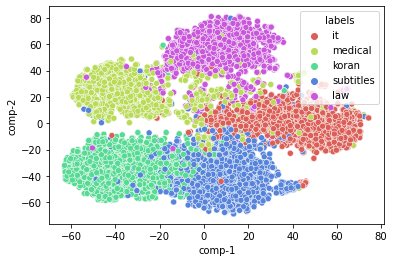

In [11]:
df = pd.DataFrame()
df["labels"] = test_embeddings['labels']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="labels", palette=sns.color_palette("hls", 5))

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

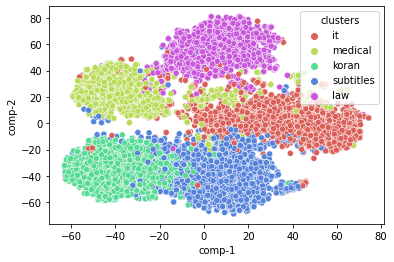

In [12]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))